<a href="https://colab.research.google.com/github/diputs03/AI-Studies/blob/main/From-tensorflow-mnist-tutorial/dynamic_architect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#@title Aiming a Dynaimic Graph-structured NeuronNetwork
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sympy

In [12]:
#@title Model Class
class Model:
  def relu(x) -> float:
    if x >= 0: return x
    else: return 0
  def sigmoid(x) -> float:
    return 1/(1 + np.e**(-x))
  def linear(x) -> float:
    return x
  def nul(x) -> float:
    return x
  class Neuron:
    name = ''
    prev, next = [], []
    bias = 0
    func = None
    def __init__(self, name, prev, next, func) -> None:
      self.name = name
      self.prev = prev
      self.next = next
      self.func = func
    def __str__(self) -> str:
      ret = str(self.name) + '('
      for n in self.next:
        ret += str(n)
      return ret + ')'
  def __init__(self, input_size, output_size):
    self.Input_layer, self.Output_layer, self.all_neurons = [], [], []
    self.links = {}
    for i in range(input_size):
      self.Input_layer += [Model.Neuron(name=f'input_{i}',
                                        prev=[], next=[], func=Model.sigmoid)]
    for o in range(output_size):
      self.Output_layer += [Model.Neuron(name=f'output_{o}',
                                         prev=[], next=[], func=Model.sigmoid)]
    for u in self.Input_layer:
      for v in self.Output_layer:
        self.links[(u,v)] = 0
        u.next.append(v)
        v.prev.append(u)
    self.all_neurons += self.Input_layer+self.Output_layer

  def __len__(self):
    return len(self.all_neurons)

  def forward(self, X):
    for x in X: assert len(x) == len(self.Input_layer), 'invalid input'
    l = len(X)
    stack = self.Input_layer.copy()
# we have to cache the input in something because this is not a layered graph
    cache, cnt = {}, {}
    for n in self.all_neurons:
      cache[n], cnt[n] = np.zeros(l), 0
    X_prime = np.array(X).T.copy()
    for i, elem in enumerate(self.Input_layer):
      cache[elem] = X_prime[i]
# stack for nodes to be pushed
    while len(stack) != 0:
      c = stack.pop()
      for e in range(l):
        cache[c][e] = c.func(cache[c][e]+c.bias)
      for n in c.next:
        for e in range(l):
          cache[n][e] += self.links[(c,n)] * cache[c][e]
        cnt[n] += 1
        if cnt[n] == len(n.prev):
          stack.append(n)
    return cache

  def eval(self, X):
    cache = self.forward(X)
    l = len(X)
    ret = [[] for _ in range(l)]
    for e in range(l):
      for o in self.Output_layer:
        ret[e] += [cache[o][e]]
    return ret

  def backward(self, X, Y, learning_rate):
    assert len(X) == len(Y), 'invalid input'
    for x in X: assert len(x) == len(self.Input_layer), 'invalid input'
    for y in Y: assert len(y) == len(self.Output_layer), 'invalid input'
    l = len(X)
    cache = self.forward(X)
    stack = self.Output_layer.copy()
    delta, cnt = {}, {}
    for n in self.all_neurons:
      delta[n], cnt[n] = np.zeros(l), 0
    Y_prime = np.array(Y).T.copy()
    for o, elem in enumerate(self.Output_layer):
      delta[elem] = Y_prime[o] - cache[elem]

    while len(stack) != 0:
      c = stack.pop()
      x = sympy.symbols('x')
#      deri = sympy.diff(c.func(x), x)
#      for e in range(l):
#        delta[c][e] *= deri.evalf(subs={x: cache[c][e]})
      delta[c] = delta[c] * np.array(cache[c]) * (1 - np.array(cache[c]))
      c.bias -= np.sum(delta[c], axis=0) * learning_rate
      for p in c.prev:
        delta[p] += self.links[(p,c)] * delta[c]
        cnt[p] += 1
        self.links[(p,c)] -= np.dot(delta[c], cache[c]) * learning_rate
        if cnt[p] == len(p.next):
          stack.append(p)
    return None

  def train(self, X, Y, batch_size, epochs, learning_rate):
    l = len(X)
    for epoch in range(epochs):
      loss = 0
      for batch in range(int(l / batch_size)):
        L, R = batch * batch_size, (batch + 1) * batch_size
        output = self.eval(X[L:R])
        self.backward(X[L:R], Y[L:R], learning_rate)
        for e in range(batch_size):
          for o in range(len(self.Output_layer)):
            loss += (Y[L + e][o]-output[e][o]) ** 2
      loss = (loss) ** 0.5
      print(f"Epoch {epoch}, Loss:{loss}")

  def __str__(self):
    ret=''
    for i in self.Input_layer:
      ret += i.__str__()
    return ret

# tests
  def Add_Node(self):
    assert(len(self.Input_layer) != 0)
    assert(len(self.Output_layer) != 0)
    u = self.Input_layer[0]
    v = self.Output_layer[0]
    self.links.pop((u, v))
    n = Model.Neuron(name=f'mid_{0}', prev=[u], next=[v], func=Model.sigmoid)
    self.links[(u, n)] = 1
    self.links[(n, v)] = 1
    self.all_neurons.append(n)
    u.next.remove(v)
    u.next.append(n)
    v.prev.remove(u)
    v.prev.append(n)
    print('new node', n)


In [13]:

# testing code
mod=Model(2, 1)
print(mod.Input_layer)
print(mod.Output_layer)
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [0]])
print(mod.eval(X))
mod.train(X, y, 1, 1000, 0.1)
mod.Add_Node()
print(mod.eval(X))
mod.train(X, y, 1, 1000, 0.1)
#mod.plot()
print(mod)
print(mod.eval(X))

[<__main__.Model.Neuron object at 0x795bdb2d19d0>, <__main__.Model.Neuron object at 0x795c0c739490>]
[[np.float64(0.5)], [np.float64(0.5)], [np.float64(0.5)], [np.float64(0.5)]]
Epoch 0, Loss:0.996879938294245
Epoch 1, Loss:0.9968799383043344
Epoch 2, Loss:0.9968799383149445
Epoch 3, Loss:0.9968799383261016
Epoch 4, Loss:0.9968799383378344
Epoch 5, Loss:0.9968799383501722
Epoch 6, Loss:0.9968799383631463
Epoch 7, Loss:0.9968799383767893
Epoch 8, Loss:0.9968799383911359
Epoch 9, Loss:0.9968799384062221
Epoch 10, Loss:0.9968799384220862
Epoch 11, Loss:0.9968799384387682
Epoch 12, Loss:0.9968799384563101
Epoch 13, Loss:0.9968799384747561
Epoch 14, Loss:0.996879938494153
Epoch 15, Loss:0.9968799385145496
Epoch 16, Loss:0.9968799385359977
Epoch 17, Loss:0.9968799385585506
Epoch 18, Loss:0.9968799385822662
Epoch 19, Loss:0.9968799386072037
Epoch 20, Loss:0.9968799386334262
Epoch 21, Loss:0.9968799386609998
Epoch 22, Loss:0.996879938689994
Epoch 23, Loss:0.9968799387204824
Epoch 24, Loss:0.99

In [241]:
import tensorflow as tf
tf.random.set_seed(42)
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Flatten images to 1D vector of 784 features (28*28)
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
mod2 = Model(784, 10)

(60000, 784)
784
Epoch 0, Loss:26.645825188948457
Epoch 1, Loss:26.645825188948457
Epoch 2, Loss:26.645825188948457
Epoch 3, Loss:26.645825188948457
Epoch 4, Loss:26.645825188948457
[[np.float64(1.074204005793608e-54), np.float64(1.074204005793608e-54), np.float64(1.074204005793608e-54), np.float64(1.074204005793608e-54), np.float64(1.074204005793608e-54), np.float64(1.0), np.float64(1.074204005793608e-54), np.float64(1.074204005793608e-54), np.float64(1.074204005793608e-54), np.float64(1.074204005793608e-54)]]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


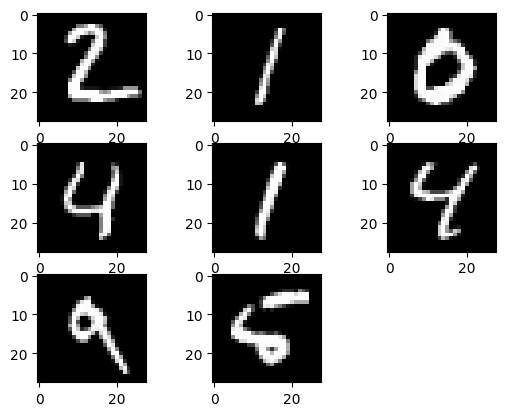

In [262]:
print(x_train.shape)
print(len(mod2.Input_layer))
mod2.train(x_train[0:500], y_train[0:500], 128, 5, 1)
for i in range(1,9):
  plt.subplot(330+i)
  plt.imshow(x_test[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
print(mod2.eval([x_test[8]]))
print(y_test[8])

In [260]:
for i in range(3, 9):
  print(mod2.eval([x_test[i]]))
  print(y_test[i])

[[np.float64(7.533012113319011e-55), np.float64(7.533012113319011e-55), np.float64(7.533012113319011e-55), np.float64(7.533012113319011e-55), np.float64(7.533012113319011e-55), np.float64(1.0), np.float64(7.533012113319011e-55), np.float64(7.533012113319011e-55), np.float64(7.533012113319011e-55), np.float64(7.533012113319011e-55)]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[np.float64(2.065898986730148e-54), np.float64(2.065898986730148e-54), np.float64(2.065898986730148e-54), np.float64(2.065898986730148e-54), np.float64(2.065898986730148e-54), np.float64(1.0), np.float64(2.065898986730148e-54), np.float64(2.065898986730148e-54), np.float64(2.065898986730148e-54), np.float64(2.065898986730148e-54)]]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[[np.float64(2.8330160650320475e-54), np.float64(2.8330160650320475e-54), np.float64(2.8330160650320475e-54), np.float64(2.8330160650320475e-54), np.float64(2.8330160650320475e-54), np.float64(1.0), np.float64(2.8330160650320475e-54), np.float64(2.8330160650320475e-

In [ ]:
#@title plotting the network, TODO://
  def plot(self):
    def blank_diagram(fig_width=16, fig_height=9,
                  bg_color="antiquewhite", color="midnightblue"):
      fig = plt.figure(figsize=(fig_width / 2.54, fig_height / 2.54))
      ax = fig.add_axes((0, 0, 1, 1))
      ax.set_xlim(0, fig_width)
      ax.set_ylim(0, fig_height)
      ax.set_facecolor(bg_color)

      ax.tick_params(bottom=False, top=False,
                    left=False, right=False)
      ax.tick_params(labelbottom=False, labeltop=False,
                    labelleft=False, labelright=False)

      ax.spines["top"].set_color(color)
      ax.spines["bottom"].set_color(color)
      ax.spines["left"].set_color(color)
      ax.spines["right"].set_color(color)
      ax.spines["top"].set_linewidth(4)
      ax.spines["bottom"].set_linewidth(4)
      ax.spines["left"].set_linewidth(4)
      ax.spines["right"].set_linewidth(4)

      return fig, ax
    fig, ax = blank_diagram()

    centers = [(3.5, 6.5), (8, 6.5), (12.5, 6.5), (8, 2.5)]
    radii = 1.5
    texts = [
        "\n".join(["My roommate", "is a Philistine", "and a boor"]),
        "\n".join(["My roommate", "ate the last", "of the", "cold cereal"]),
        "\n".join(["I am really", "really hungy"]),
        "\n".join(["I'm annoyed", "at my roommate"]),
    ]

    # Draw circles with text in the center

    for i, center in enumerate(centers):
        x, y = center
        theta = np.linspace(0, 2 * np.pi, 100)
        ax.plot(
            x + radii * np.cos(theta),
            y + radii * np.sin(theta),
            color="midnightblue",
        )
        ax.text(
            x, y,
            texts[i],
            horizontalalignment="center",
            verticalalignment="center",
            color="midnightblue",
        )

    ax.annotate(
        "",
        (centers[1][0] - radii, centers[1][1]),
        (centers[0][0] + radii, centers[0][1]),
        arrowprops=dict(arrowstyle = "-|>"),
    )
    ax.annotate(
        "",
        (centers[2][0] - radii, centers[2][1]),
        (centers[1][0] + radii, centers[1][1]),
        arrowprops=dict(arrowstyle = "-|>"),
    )
    ax.annotate(
        "",
        (centers[3][0] - .7 * radii, centers[3][1] + .7 * radii),
        (centers[0][0] + .7 * radii, centers[0][1] - .7 * radii),
        arrowprops=dict(arrowstyle = "-|>"),
    )
    ax.annotate(
        "",
        (centers[3][0] + .7 * radii, centers[3][1] + .7 * radii),
        (centers[2][0] - .7 * radii, centers[2][1] - .7 * radii),
        arrowprops=dict(arrowstyle = "-|>"),
    )
    fig.show()